In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pytorch-msssim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 106.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 116.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [3]:
# DnCNN Model Definition, Data Prep, and Training Loop for Colab
"""
Define, inspect, prepare data, and train the DnCNN denoiser interactively in a Colab notebook.
Includes utilities for computing dataset statistics, loading from ZIPs, and a basic train/val loop
that tracks both MSE loss and SSIM.
"""
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import DataLoader
import zipfile, io
from PIL import Image
from tqdm import tqdm
import math
from pathlib import Path
import torch.nn.functional as F
from pytorch_msssim import ssim
import os
import random
import matplotlib.pyplot as plt


In [4]:
# ---------------------------------------------
# 1. RIDNet Definition
# ---------------------------------------------
class FeatureAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        scale = self.fc(self.pool(x))
        return x * scale

class EAMBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.dilated_conv1 = nn.Conv2d(channels, channels, 3, padding=1, dilation=1)
        self.dilated_conv2 = nn.Conv2d(channels, channels, 3, padding=2, dilation=2)
        self.residual = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1)
        )
        self.enhanced = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1)
        )
        self.attention = FeatureAttention(channels)
    def forward(self, x):
        d1 = self.dilated_conv1(x)
        d2 = self.dilated_conv2(x)
        merged = d1 + d2
        res = self.residual(merged) + merged
        enh = self.enhanced(res) + res
        out = self.attention(enh)
        return out + x

class RIDNet(nn.Module):
    def __init__(self, in_channels=1, num_features=64, num_blocks=4):
        super().__init__()
        self.entry = nn.Conv2d(in_channels, num_features, 3, padding=1)
        self.blocks = nn.Sequential(*[EAMBlock(num_features) for _ in range(num_blocks)])
        self.exit = nn.Conv2d(num_features, in_channels, 3, padding=1)
    def forward(self, x):
        identity = x
        out = self.entry(x)
        out = self.blocks(out)
        out = self.exit(out)
        return identity - out


In [5]:
# ---------------------------------------------
# 2. Transforms with Resize
# ---------------------------------------------
mean, std = [0.1781], [0.1976]
target_size = (256,256)
train_tf = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
val_tf = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [6]:
# ---------------------------------------------
# 3. Paired ZIP Dataset Loader
# ---------------------------------------------
class PairedZipDataset(torch.utils.data.Dataset):
    def __init__(self, clean_zip, noisy_zip, transform=None):
        self.clean_zip_path = clean_zip
        self.noisy_zip_path = noisy_zip
        with zipfile.ZipFile(clean_zip, 'r') as zc:
            self.fnames = sorted(
                Path(f).name for f in zc.namelist()
                if f.startswith('clean/') and f.lower().endswith(('.png','.jpg','.jpeg','.tif','.tiff'))
            )
        self.transform = transform or (lambda x: x)
        self.zc, self.zn = None, None
    def __len__(self): return len(self.fnames)
    def __getitem__(self, idx):
        if self.zc is None: self.zc = zipfile.ZipFile(self.clean_zip_path)
        if self.zn is None: self.zn = zipfile.ZipFile(self.noisy_zip_path)
        fname = self.fnames[idx]
        clean = Image.open(io.BytesIO(self.zc.read(f'clean/{fname}'))).convert('L')
        noisy = Image.open(io.BytesIO(self.zn.read(f'noisy_15_awgn/{fname}'))).convert('L')
        return self.transform(noisy), self.transform(clean)

In [7]:
# ---------------------------------------------
# 4. Training Loop with Denormalized Metrics & Early Stopping
# ---------------------------------------------
def train_model(model, train_loader, val_loader, epochs=50, lr=1e-3,
                patience=5, checkpoint_dir='checkpoints', device=None):
    print(f">>> train_model called: epochs={epochs}, lr={lr}, patience={patience}")
    device = device or (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    os.makedirs(checkpoint_dir, exist_ok=True)
    best_val_loss, epochs_no_improve = float('inf'), 0

    for ep in range(1, epochs+1):
        print(f"--- Starting Epoch {ep}/{epochs} ---")
        model.train()
        train_loss = train_ssim_sum = 0.0
        for noisy, clean in tqdm(train_loader, desc=f"Epoch {ep}/{epochs} [Train]", leave=False):
            noisy, clean = noisy.to(device), clean.to(device)
            pred = model(noisy)
            loss = criterion(pred, clean)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            train_loss += loss.item() * noisy.size(0)
            batch_ssim = ssim(pred, clean, data_range=1.0, size_average=True).item()
            train_ssim_sum += batch_ssim * noisy.size(0)
        train_loss /= len(train_loader.dataset)
        train_ssim = train_ssim_sum / len(train_loader.dataset)

        model.eval()
        val_loss = val_ssim_sum = psnr_sum = 0.0
        for noisy, clean in tqdm(val_loader, desc=f"Epoch {ep}/{epochs} [Val]", leave=False):
            noisy, clean = noisy.to(device), clean.to(device)
            pred = model(noisy)
            val_loss += criterion(pred, clean).item() * noisy.size(0)
            batch_ssim = ssim(pred, clean, data_range=1.0, size_average=True).item()
            val_ssim_sum += batch_ssim * noisy.size(0)
            mse = (pred-clean).pow(2).mean().item()
            psnr_sum += 10 * math.log10(1.0 / mse) * noisy.size(0)
        val_loss /= len(val_loader.dataset)
        val_ssim = val_ssim_sum / len(val_loader.dataset)
        avg_psnr = psnr_sum / len(val_loader.dataset)

        print(f"Epoch {ep}/{epochs}: Train MSE={train_loss:.4f}, Train SSIM={train_ssim:.4f} | "
              f"Val MSE={val_loss:.4f}, Val SSIM={val_ssim:.4f}, Val PSNR={avg_psnr:.2f}dB")

        if val_loss < best_val_loss:
            best_val_loss = val_loss; epochs_no_improve = 0
            ckpt = os.path.join(checkpoint_dir, f'best_ep{ep}.pth')
            torch.save(model.state_dict(), ckpt)
            print(f"  Saved checkpoint: {ckpt}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {ep}")
                break

In [8]:
# ---------------------------------------------
# 5. DataLoaders & Training
# ---------------------------------------------
train_ds = PairedZipDataset('/content/drive/MyDrive/IA2/dataset/train_clean.zip','/content/drive/MyDrive/IA2/dataset/train_noisy_15_awgn.zip',train_tf)
val_ds   = PairedZipDataset('/content/drive/MyDrive/IA2/dataset/val_clean.zip','/content/drive/MyDrive/IA2/dataset/val_noisy_15_awgn.zip',val_tf)
train_loader = DataLoader(train_ds,batch_size=8,shuffle=True,num_workers=0)
val_loader   = DataLoader(val_ds,  batch_size=8,shuffle=True,num_workers=0)
model = RIDNet(in_channels=1,num_features=64,num_blocks=4)
train_model(model,train_loader,val_loader)

>>> train_model called: epochs=50, lr=0.001, patience=5
--- Starting Epoch 1/50 ---


Epoch 1/50: Train MSE=0.0913, Train SSIM=0.5140 | Val MSE=0.0624, Val SSIM=0.5592, Val PSNR=12.17dB
  Saved checkpoint: checkpoints/best_ep1.pth
--- Starting Epoch 2/50 ---


Epoch 2/50: Train MSE=0.0555, Train SSIM=0.5727 | Val MSE=0.0477, Val SSIM=0.5939, Val PSNR=13.38dB
  Saved checkpoint: checkpoints/best_ep2.pth
--- Starting Epoch 3/50 ---


Epoch 3/50: Train MSE=0.0497, Train SSIM=0.5876 | Val MSE=0.0449, Val SSIM=0.6151, Val PSNR=13.65dB
  Saved checkpoint: checkpoints/best_ep3.pth
--- Starting Epoch 4/50 ---


Epoch 4/50: Train MSE=0.0464, Train SSIM=0.6022 | Val MSE=0.0430, Val SSIM=0.6260, Val PSNR=13.84dB
  Saved checkpoint: checkpoints/best_ep4.pth
--- Starting Epoch 5/50 ---


Epoch 5/50: Train MSE=0.0451, Train SSIM=0.6132 | Val MSE=0.0432, Val SSIM=0.6233, Val PSNR=13.81dB
--- Starting Epoch 6/50 ---


Epoch 6/50: Train MSE=0.0831, Train SSIM=0.6089 | Val MSE=0.5024, Val SSIM=0.0799, Val PSNR=3.10dB
--- Starting Epoch 7/50 ---


Epoch 7/50: Train MSE=303806173386764248416256.0000, Train SSIM=0.0001 | Val MSE=282022012924578009972736.0000, Val SSIM=0.0000, Val PSNR=-233.35dB
--- Starting Epoch 8/50 ---


Epoch 8/50: Train MSE=333413339520958975705088.0000, Train SSIM=-0.0000 | Val MSE=278651961541196511182848.0000, Val SSIM=0.0000, Val PSNR=-233.34dB
--- Starting Epoch 9/50 ---


KeyboardInterrupt: 

In [9]:
# ---------------------------------------------
# 6. Sync checkpoints to Google Drive
# ---------------------------------------------
import shutil

dst_dir = '/content/drive/MyDrive/IA2/ridnet_checkpoints_15_awgn'
shutil.copytree('checkpoints', dst_dir, dirs_exist_ok=True)
print(f"Checkpoints have been copied to {dst_dir}")


Checkpoints have been copied to /content/drive/MyDrive/IA2/ridnet_checkpoints_15_awgn


In [13]:
# ---------------------------------------------
# 7. Load Best Checkpoint for Evaluation
# ---------------------------------------------
# Replace with your checkpoint path
best_ckpt = '/content/drive/MyDrive/IA2/ridnet_checkpoints/best_ep5.pth'
model.load_state_dict(torch.load(best_ckpt))
# Continue training for 45 more epochs
train_model(model,
            train_loader,
            val_loader,
            epochs=45,
            lr=1e-5,
            patience=5,
            checkpoint_dir='checkpoints_ridnet_finetune')


>>> train_model called: epochs=45, lr=1e-05, patience=5
--- Starting Epoch 1/45 ---


Epoch 1/45: Train MSE=0.0792, Train SSIM=0.3754 | Val MSE=0.0641, Val SSIM=0.4617, Val PSNR=12.10dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep1.pth
--- Starting Epoch 2/45 ---


Epoch 2/45: Train MSE=0.0601, Train SSIM=0.4974 | Val MSE=0.0565, Val SSIM=0.5185, Val PSNR=12.65dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep2.pth
--- Starting Epoch 3/45 ---


Epoch 3/45: Train MSE=0.0552, Train SSIM=0.5338 | Val MSE=0.0532, Val SSIM=0.5477, Val PSNR=12.90dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep3.pth
--- Starting Epoch 4/45 ---


Epoch 4/45: Train MSE=0.0527, Train SSIM=0.5528 | Val MSE=0.0517, Val SSIM=0.5593, Val PSNR=13.03dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep4.pth
--- Starting Epoch 5/45 ---


Epoch 5/45: Train MSE=0.0512, Train SSIM=0.5661 | Val MSE=0.0500, Val SSIM=0.5747, Val PSNR=13.18dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep5.pth
--- Starting Epoch 6/45 ---


Epoch 6/45: Train MSE=0.0500, Train SSIM=0.5763 | Val MSE=0.0490, Val SSIM=0.5827, Val PSNR=13.27dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep6.pth
--- Starting Epoch 7/45 ---


Epoch 7/45: Train MSE=0.0491, Train SSIM=0.5839 | Val MSE=0.0482, Val SSIM=0.5900, Val PSNR=13.35dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep7.pth
--- Starting Epoch 8/45 ---


Epoch 8/45: Train MSE=0.0484, Train SSIM=0.5905 | Val MSE=0.0477, Val SSIM=0.5953, Val PSNR=13.38dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep8.pth
--- Starting Epoch 9/45 ---


Epoch 9/45: Train MSE=0.0479, Train SSIM=0.5957 | Val MSE=0.0472, Val SSIM=0.5994, Val PSNR=13.45dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep9.pth
--- Starting Epoch 10/45 ---


Epoch 10/45: Train MSE=0.0474, Train SSIM=0.6000 | Val MSE=0.0467, Val SSIM=0.6043, Val PSNR=13.48dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep10.pth
--- Starting Epoch 11/45 ---


Epoch 11/45: Train MSE=0.0469, Train SSIM=0.6038 | Val MSE=0.0463, Val SSIM=0.6073, Val PSNR=13.53dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep11.pth
--- Starting Epoch 12/45 ---


Epoch 12/45: Train MSE=0.0466, Train SSIM=0.6070 | Val MSE=0.0459, Val SSIM=0.6110, Val PSNR=13.54dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep12.pth
--- Starting Epoch 13/45 ---


Epoch 13/45: Train MSE=0.0463, Train SSIM=0.6098 | Val MSE=0.0457, Val SSIM=0.6142, Val PSNR=13.56dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep13.pth
--- Starting Epoch 14/45 ---


Epoch 14/45: Train MSE=0.0460, Train SSIM=0.6123 | Val MSE=0.0455, Val SSIM=0.6140, Val PSNR=13.59dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep14.pth
--- Starting Epoch 15/45 ---


Epoch 15/45: Train MSE=0.0457, Train SSIM=0.6145 | Val MSE=0.0451, Val SSIM=0.6186, Val PSNR=13.63dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep15.pth
--- Starting Epoch 16/45 ---


Epoch 16/45: Train MSE=0.0454, Train SSIM=0.6165 | Val MSE=0.0449, Val SSIM=0.6196, Val PSNR=13.66dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep16.pth
--- Starting Epoch 17/45 ---


Epoch 17/45: Train MSE=0.0452, Train SSIM=0.6183 | Val MSE=0.0448, Val SSIM=0.6214, Val PSNR=13.66dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep17.pth
--- Starting Epoch 18/45 ---


Epoch 18/45: Train MSE=0.0450, Train SSIM=0.6199 | Val MSE=0.0445, Val SSIM=0.6236, Val PSNR=13.70dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep18.pth
--- Starting Epoch 19/45 ---


Epoch 19/45: Train MSE=0.0448, Train SSIM=0.6214 | Val MSE=0.0443, Val SSIM=0.6239, Val PSNR=13.70dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep19.pth
--- Starting Epoch 20/45 ---


Epoch 20/45: Train MSE=0.0446, Train SSIM=0.6226 | Val MSE=0.0441, Val SSIM=0.6262, Val PSNR=13.71dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep20.pth
--- Starting Epoch 21/45 ---


Epoch 21/45: Train MSE=0.0444, Train SSIM=0.6238 | Val MSE=0.0439, Val SSIM=0.6266, Val PSNR=13.73dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep21.pth
--- Starting Epoch 22/45 ---


Epoch 22/45: Train MSE=0.0442, Train SSIM=0.6248 | Val MSE=0.0438, Val SSIM=0.6273, Val PSNR=13.77dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep22.pth
--- Starting Epoch 23/45 ---


Epoch 23/45: Train MSE=0.0441, Train SSIM=0.6260 | Val MSE=0.0436, Val SSIM=0.6285, Val PSNR=13.79dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep23.pth
--- Starting Epoch 24/45 ---


Epoch 24/45: Train MSE=0.0439, Train SSIM=0.6268 | Val MSE=0.0437, Val SSIM=0.6292, Val PSNR=13.76dB
--- Starting Epoch 25/45 ---


Epoch 25/45: Train MSE=0.0438, Train SSIM=0.6278 | Val MSE=0.0433, Val SSIM=0.6296, Val PSNR=13.79dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep25.pth
--- Starting Epoch 26/45 ---


Epoch 26/45: Train MSE=0.0436, Train SSIM=0.6285 | Val MSE=0.0433, Val SSIM=0.6303, Val PSNR=13.82dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep26.pth
--- Starting Epoch 27/45 ---


Epoch 27/45: Train MSE=0.0435, Train SSIM=0.6293 | Val MSE=0.0431, Val SSIM=0.6313, Val PSNR=13.81dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep27.pth
--- Starting Epoch 28/45 ---


Epoch 28/45: Train MSE=0.0434, Train SSIM=0.6300 | Val MSE=0.0430, Val SSIM=0.6319, Val PSNR=13.83dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep28.pth
--- Starting Epoch 29/45 ---


Epoch 29/45: Train MSE=0.0433, Train SSIM=0.6308 | Val MSE=0.0428, Val SSIM=0.6333, Val PSNR=13.84dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep29.pth
--- Starting Epoch 30/45 ---


Epoch 30/45: Train MSE=0.0431, Train SSIM=0.6313 | Val MSE=0.0427, Val SSIM=0.6338, Val PSNR=13.88dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep30.pth
--- Starting Epoch 31/45 ---


Epoch 31/45: Train MSE=0.0430, Train SSIM=0.6321 | Val MSE=0.0426, Val SSIM=0.6347, Val PSNR=13.89dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep31.pth
--- Starting Epoch 32/45 ---


Epoch 32/45: Train MSE=0.0429, Train SSIM=0.6326 | Val MSE=0.0425, Val SSIM=0.6349, Val PSNR=13.88dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep32.pth
--- Starting Epoch 33/45 ---


Epoch 33/45: Train MSE=0.0428, Train SSIM=0.6331 | Val MSE=0.0424, Val SSIM=0.6343, Val PSNR=13.88dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep33.pth
--- Starting Epoch 34/45 ---


Epoch 34/45: Train MSE=0.0427, Train SSIM=0.6337 | Val MSE=0.0423, Val SSIM=0.6354, Val PSNR=13.91dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep34.pth
--- Starting Epoch 35/45 ---


Epoch 35/45: Train MSE=0.0426, Train SSIM=0.6342 | Val MSE=0.0422, Val SSIM=0.6360, Val PSNR=13.92dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep35.pth
--- Starting Epoch 36/45 ---


Epoch 36/45: Train MSE=0.0425, Train SSIM=0.6347 | Val MSE=0.0422, Val SSIM=0.6360, Val PSNR=13.91dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep36.pth
--- Starting Epoch 37/45 ---


Epoch 37/45: Train MSE=0.0424, Train SSIM=0.6352 | Val MSE=0.0421, Val SSIM=0.6370, Val PSNR=13.93dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep37.pth
--- Starting Epoch 38/45 ---


Epoch 38/45: Train MSE=0.0423, Train SSIM=0.6357 | Val MSE=0.0420, Val SSIM=0.6378, Val PSNR=13.94dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep38.pth
--- Starting Epoch 39/45 ---


Epoch 39/45: Train MSE=0.0422, Train SSIM=0.6361 | Val MSE=0.0419, Val SSIM=0.6363, Val PSNR=13.93dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep39.pth
--- Starting Epoch 40/45 ---


Epoch 40/45: Train MSE=0.0422, Train SSIM=0.6365 | Val MSE=0.0418, Val SSIM=0.6393, Val PSNR=13.96dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep40.pth
--- Starting Epoch 41/45 ---


Epoch 41/45: Train MSE=0.0421, Train SSIM=0.6370 | Val MSE=0.0418, Val SSIM=0.6378, Val PSNR=13.96dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep41.pth
--- Starting Epoch 42/45 ---


Epoch 42/45: Train MSE=0.0420, Train SSIM=0.6373 | Val MSE=0.0417, Val SSIM=0.6393, Val PSNR=13.96dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep42.pth
--- Starting Epoch 43/45 ---


Epoch 43/45: Train MSE=0.0419, Train SSIM=0.6378 | Val MSE=0.0416, Val SSIM=0.6389, Val PSNR=13.96dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep43.pth
--- Starting Epoch 44/45 ---


Epoch 44/45: Train MSE=0.0418, Train SSIM=0.6381 | Val MSE=0.0415, Val SSIM=0.6390, Val PSNR=13.99dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep44.pth
--- Starting Epoch 45/45 ---


Epoch 45/45: Train MSE=0.0418, Train SSIM=0.6384 | Val MSE=0.0415, Val SSIM=0.6393, Val PSNR=13.99dB
  Saved checkpoint: checkpoints_ridnet_finetune/best_ep45.pth


In [14]:
# ---------------------------------------------
# 6. Sync checkpoints to Google Drive
# ---------------------------------------------
import shutil

dst_dir = '/content/drive/MyDrive/IA2/ridnet_checkpoints_15_awgn_finetune'
shutil.copytree('/content/checkpoints_ridnet_finetune', dst_dir, dirs_exist_ok=True)
print(f"Checkpoints have been copied to {dst_dir}")


Checkpoints have been copied to /content/drive/MyDrive/IA2/ridnet_checkpoints_15_awgn_finetune


In [11]:
# ---------------------------------------------
# 8. Test Set Evaluation
# ---------------------------------------------
# Initialize a fresh RIDNet for testing
# (checkpoint path to be set by user)
model = RIDNet(in_channels=1, num_features=64, num_blocks=4)
# Load best checkpoint (replace with your own path)
best_ckpt = '/content/drive/MyDrive/IA2/ridnet_checkpoints_15_awgn_finetune/best_ep40.pth'
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Prepare test DataLoader
test_ds = PairedZipDataset('/content/drive/MyDrive/IA2/dataset/test_clean.zip', '/content/drive/MyDrive/IA2/dataset/test_noisy_15_awgn.zip', val_tf)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=0)

# Collect per-instance metrics
all_mse, all_ssim, all_psnr = [], [], []
with torch.no_grad():
    for noisy, clean in tqdm(test_loader, desc='Testing'):
        noisy, clean = noisy.to(device), clean.to(device)
        pred = model(noisy)
        # denormalize predictions and targets
        pd = pred * std[0] + mean[0]
        cd = clean * std[0] + mean[0]
        # per-image MSE
        per_mse = ((pd - cd) ** 2).mean(dim=[1,2,3]).cpu().tolist()
        all_mse.extend(per_mse)
        # per-image SSIM
        batch_ssim = ssim(pd, cd, data_range=1.0, size_average=False).cpu().tolist()
        all_ssim.extend(batch_ssim)
        # per-image PSNR
        all_psnr.extend([10 * math.log10(1.0 / m) for m in per_mse])

# Compute and print averages
test_mse = sum(all_mse) / len(all_mse)
test_ssim = sum(all_ssim) / len(all_ssim)
test_psnr = sum(all_psnr) / len(all_psnr)
print(f"Test MSE: {test_mse:.4f}")
print(f"Test SSIM: {test_ssim:.4f}")
print(f"Test PSNR: {test_psnr:.2f} dB")


Testing: 100%|██████████| 250/250 [01:15<00:00,  3.31it/s]

Test MSE: 0.0159
Test SSIM: 0.1159
Test PSNR: 18.03 dB


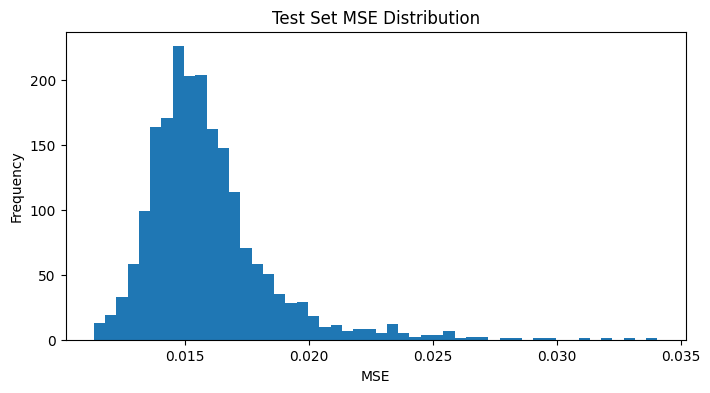

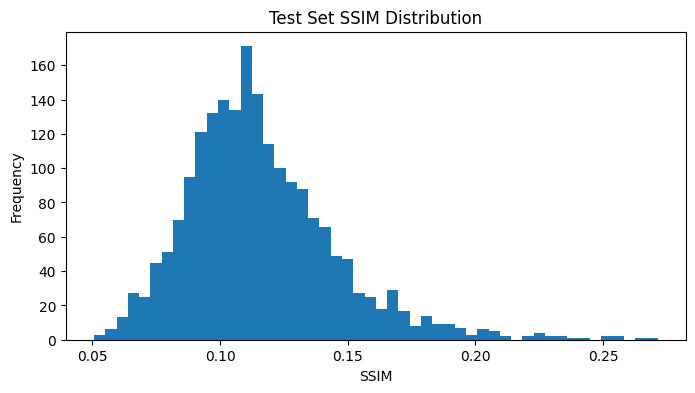

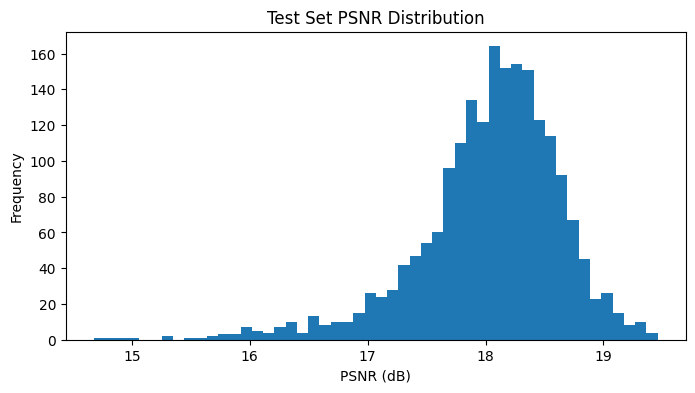

In [12]:
# ---------------------------------------------
# 9. Plot Histograms of Test Metrics
# ---------------------------------------------
plt.figure(figsize=(8,4))
plt.hist(all_mse, bins=50)
plt.title('Test Set MSE Distribution')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8,4))
plt.hist(all_ssim, bins=50)
plt.title('Test Set SSIM Distribution')
plt.xlabel('SSIM')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8,4))
plt.hist(all_psnr, bins=50)
plt.title('Test Set PSNR Distribution')
plt.xlabel('PSNR (dB)')
plt.ylabel('Frequency')
plt.show()


In [13]:
# ---------------------------------------------
# 8. Sample Visualizations
# ---------------------------------------------
indices=random.sample(range(len(test_ds)),10)
fig,ax=plt.subplots(10,3,figsize=(9,30))
for i,idx in enumerate(indices):
    n,c=test_ds[idx]
    d=model(n.unsqueeze(0).to(device)).squeeze(0).cpu()
    def den(t):
        # Denormalize and convert to numpy for display
        t_den = t.detach() * std[0] + mean[0]
        return t_den.cpu().numpy().squeeze()
    ax[i,0].imshow(den(d),cmap='gray'); ax[i,0].axis('off'); ax[i,0].set_title('Noisy')
    ax[i,1].imshow(den(n),cmap='gray'); ax[i,1].axis('off'); ax[i,1].set_title('Denoised')
    ax[i,2].imshow(den(c),cmap='gray'); ax[i,2].axis('off'); ax[i,2].set_title('Clean')
plt.tight_layout(); plt.show()

Output hidden; open in https://colab.research.google.com to view.